<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Посимвольная-токенизация">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Посимвольная токенизация
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Токенизация-символов">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Токенизация символов
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Построение-модели">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Построение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.3-Обучение-модели">
                            <span class="toc-item-num">3.3&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.4-Генерация-текста">
                            <span class="toc-item-num">3.4&nbsp;&nbsp;</span>
                            Генерация текста
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративные текстовые нейросети | Simple RNN (посимвольная)

**Постановка задачи:** натренировать и сравнить качество нескольких генеративных текстовых моделей на одном из заданных текстовых датасетов.

**Источник данных:** [Harry Potter and the Methods of Rationality](https://hpmor.ru/).

**Характер данных:** текст книги "Гарри Поттер и методы рационального мышления".

**Основные этапы:** исследовать следующие нейросетевые архитектуры:

1. Simple RNN с посимвольной и пословной токенизацией.
2. Однонаправленная однослойная и многослойная LSTM c посимвольной токенизацией и токенизацией по словам и [на основе BPE](https://keras.io/api/keras_nlp/tokenizers/byte_pair_tokenizer/).
3. Двунаправленная LSTM.
4. *(На хорошую оценку)* трансформерная архитектура (GPT) "с нуля" [пример](https://keras.io/examples/generative/text_generation_gpt/).
5. *(На отличную оценку)* дообучение предобученной GPT-сети [пример](https://github.com/ZotovaElena/RuGPT3_finetuning).

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

# Реализации

1. RNN с посимвольной токенизацией (текущий файл)
2. [RNN с пословной токенизацией](https://github.com/MAILabs-Edu-2023/magai_lab3_gennn-nlp_lab/blob/main/RNN_word.ipynb)
3. [Однонаправленная LSTM + BPE](https://github.com/MAILabs-Edu-2023/magai_lab3_gennn-nlp_lab/blob/main/unidirectional_LSTM_BPE.ipynb)
4. [Двунаправленная LSTM](https://github.com/MAILabs-Edu-2023/magai_lab3_gennn-nlp_lab/blob/main/bidirectional_LSTM.ipynb)
5. [Архитектура GPT](https://github.com/MAILabs-Edu-2023/magai_lab3_gennn-nlp_lab/blob/main/GPT_architecture.ipynb)
6. [Дообучение GPT](https://github.com/MAILabs-Edu-2023/magai_lab3_gennn-nlp_lab/blob/main/GPT_finetuning.ipynb)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Установка необходимых библиотек:

In [1]:
%%capture --no-display
!pip install requests beautifulsoup4 pydot pydotplus ipywidgets

Импорт библиотек:

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

from typing import Tuple
import random
import requests
import os
import itertools
import re

from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow import keras

from keras import Sequential
from keras.callbacks import ModelCheckpoint, History
from keras.layers import Dense, LSTM, Embedding
from keras.losses import SparseCategoricalCrossentropy
from keras.utils import plot_model

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 2 Загрузка данных

Задание функции, получающей текстовое представление веб-страницы:

In [3]:
def request_url(url: str) -> BeautifulSoup:
    request = requests.get(url)
    soup = BeautifulSoup(request.content, 'html.parser')
    return soup

Задание функции, вычленяющей необходимые данные с веб-страницы:

In [4]:
def get_url_data(url: str) -> list:
    soup = request_url(url)
    scrapped_text = []
    
    h1 = soup.h1.text.strip()
    p = soup.find_all('p')
    
    scrapped_text.append(h1)
    scrapped_text.extend([p_i.text.strip() for p_i in p])
    
    return scrapped_text

Задание функции, формирующей набор данных:

In [5]:
def get_data(url: str) -> list:
    soup = request_url(url)
    text = []
    
    text.extend([
        soup.h1.text.strip() + '.',
        soup.h2.text.strip() + '.',
        soup.article.p.text.strip()
    ])
    
    url_chapters = [link.get('href') for link in soup.find_all('a', class_='link')]
    
    for url in url_chapters:
        scrapped_text = get_url_data(url)
        text.extend(scrapped_text)
        
    text = ' '.join(text).lower()
    
    return text

---

Проверка наличия папки для хранения наборов данных:

In [6]:
if os.path.isdir('data/') == False:
    os.mkdir('data/')

Задание пути к файлу с основным набором данных:

In [7]:
path_file = 'data/hpmor.txt'

Формирование/загрузка набора данных в зависимости от его наличия:

In [8]:
try:
    with open(path_file, 'r', encoding='utf-8') as file:
        text = file.read()
    
    print('Uploaded from', path_file)
    
except:
    text = get_data('https://hpmor.ru/')
    
    with open(path_file, 'w', encoding='utf-8') as file:
        file.write(text)
    
    print('Saved to', path_file)

Uploaded from data/hpmor.txt


Выведение на экран начала текста:

In [9]:
text[:500]

'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду. у него были частные учителя, дискуссии с отцом, а главное — книги, сотни и тысячи научных и фантастических книг. в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами. но гарри не просто вундеркинд, у него есть загадочная тёмная сторона, которая явн'

Выведение на экран общего числа слов в тексте:

In [10]:
print('Всего слов:', len(text.split(' ')))

Всего слов: 559855


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Посимвольная токенизация

### 3.1 Токенизация символов

Получение словаря уникальных символов текста:

In [11]:
vocabulary_char = np.array(sorted(set(text)))

Выведение на экран уникальных символов текста:

In [12]:
vocabulary_char

array(['\n', ' ', '!', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-',
       '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':',
       ';', '=', '?', '[', '\\', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's',
       't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', '×', 'é', 'ð', 'ó',
       'þ', '́', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к',
       'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч',
       'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'ѝ', '–', '—', '’',
       '“', '”', '„', '…', '№', '∀', '∄', '−'], dtype='<U1')

Формирование словаря токенов:

In [13]:
tokenizer_char = {char: i for i, char in enumerate(vocabulary_char)}

Выведение на экран словаря токенов:

In [14]:
list(zip(list(tokenizer_char.keys())[:10], list(tokenizer_char.values())[:10]))

[('\n', 0),
 (' ', 1),
 ('!', 2),
 ('#', 3),
 ('$', 4),
 ('%', 5),
 ('&', 6),
 ('(', 7),
 (')', 8),
 ('*', 9)]

---

### 3.2 Формирование датасета

Задание функции, выводящей исходный текст с его векторным представлением:

In [15]:
def text_vector_sample(text: str or list, 
                       vector: np.array, 
                       end: int = 100) -> None:
    
    print('Исходный текст:\n', text[:end], '\n')
    print('Векторное представление:\n', vector[:end])

Задание функции, выводящей один батч из датасета:

In [16]:
def print_single_batch(dataset: Dataset,
                       vocabulary: np.array,
                       word: bool = False) -> None:
    
    for vector_single, target_single in dataset.take(1):
        print('Векторное представление:')
        print(vector_single.numpy())
        print(target_single.numpy())
        
        if word == True:
            vector_single_text = ' '.join(list(vocabulary[word.numpy()] for word in vector_single))
            target_single_text = ' '.join(list(vocabulary[word.numpy()] for word in target_single))
        else:
            vector_single_text = ''.join(vocabulary[vector_single])
            target_single_text = ''.join(vocabulary[target_single])

        print('\nПеревод в текст:')
        print(repr(vector_single_text))
        print(repr(target_single_text))

Задание функции, выводящей размерность одного элемента датасета:

In [17]:
def print_single_dim(data) -> None:
    for vector_single, target_single in data.take(1):
        print('Размерность входящей последовательности:', vector_single.numpy().shape)
        print('Размерность целевой последовательности:', target_single.numpy().shape)

Задание функции, формирующей входящие последовательности и соответствующие им последовательности следующих символов:

In [18]:
def prepare_dataset(seq: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    input_vector = seq[:-1]
    target_vector = seq[1:]
    return input_vector, target_vector

Задание функции, получающей предсказания на одном элементе датасета:

In [19]:
def test_single_model(model, data, vocabulary: dict) -> None:
    for vector_single, target_single in data.take(1):
        vector_single_pred = model(vector_single)
        ids = tf.random.categorical(vector_single_pred[0], num_samples=1)
        id_pred = ids[0][-1].numpy()

        print('Размерность целевой последовательности:', target_single.numpy().shape)
        print('Размерность предсказанной последовательности:', vector_single_pred.shape)
        print('Размерность тензора с 1 индексом классов', ids.shape)
        print(f'Индекс класса: {id_pred} ({vocabulary[id_pred]})')

---

Преобразование текста в вектор на основе токенов:

In [20]:
vector_char = np.array([tokenizer_char[char] for char in text])

Выведение на экран части исходного текста и его векторного представления:

In [21]:
text_vector_sample(text, vector_char)

Исходный текст:
 гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не 

Векторное представление:
 [70 67 83 83 75  1 82 81 85 85 72 83  1 75  1 79 72 85 81 71 94  1 83 67
 89 75 81 80 67 78 95 80 81 70 81  1 79 94 91 78 72 80 75 98 13  1 96 78
 75 72 74 72 83  1 97 71 77 81 69 84 77 75 76  1  7 44 37 51 51  1 55 50
 47 46 39  8 13  1 82 72 85 86 80 75 98  1 69 94 91 78 67  1 74 67 79 86
 73  1 80 72]


Формирование набора данных из срезов вектора текста:

In [22]:
vector_char = Dataset.from_tensor_slices(vector_char)

Формирование последовательностей по заданному количеству символов:

In [23]:
sequences_char = vector_char.batch(100, drop_remainder=True) 

Формирование датасета:

In [24]:
dataset_char = sequences_char.map(prepare_dataset)

Выведение на экран первой входящей последовательности и соответствующего ей сдвига:

In [25]:
print_single_batch(dataset_char, vocabulary_char)

Векторное представление:
[70 67 83 83 75  1 82 81 85 85 72 83  1 75  1 79 72 85 81 71 94  1 83 67
 89 75 81 80 67 78 95 80 81 70 81  1 79 94 91 78 72 80 75 98 13  1 96 78
 75 72 74 72 83  1 97 71 77 81 69 84 77 75 76  1  7 44 37 51 51  1 55 50
 47 46 39  8 13  1 82 72 85 86 80 75 98  1 69 94 91 78 67  1 74 67 79 86
 73  1 80]
[67 83 83 75  1 82 81 85 85 72 83  1 75  1 79 72 85 81 71 94  1 83 67 89
 75 81 80 67 78 95 80 81 70 81  1 79 94 91 78 72 80 75 98 13  1 96 78 75
 72 74 72 83  1 97 71 77 81 69 84 77 75 76  1  7 44 37 51 51  1 55 50 47
 46 39  8 13  1 82 72 85 86 80 75 98  1 69 94 91 78 67  1 74 67 79 86 73
  1 80 72]

Перевод в текст:
'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж н'
'арри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не'


Задание констант:

In [26]:
BATCH_SIZE = 64
BATCHES_PER_EPOCH = len(sequences_char) // BATCH_SIZE

Формирование датасета с делением на батчи:

In [27]:
data_char = dataset_char.batch(BATCH_SIZE, drop_remainder=True).repeat()
data_char = data_char.prefetch(AUTOTUNE)

Выведение на экран размерностей первой входящей последовательности и соответствующего ей сдвига:

In [28]:
print_single_dim(data_char)

Размерность входящей последовательности: (64, 99)
Размерность целевой последовательности: (64, 99)


---

### 3.2 Построение модели

Задание объекта модели RNN:

In [29]:
rnn_char = Sequential([
    Embedding(len(vocabulary_char), BATCH_SIZE, batch_input_shape=[BATCH_SIZE, None]),
    LSTM(512, return_sequences=True, stateful=True),
    LSTM(512, return_sequences=True, stateful=True),
    Dense(len(vocabulary_char))
])

Выведение на экран таблицы поведения параметров на словях нейросети:

In [30]:
rnn_char.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 64)            7168      
                                                                 
 lstm (LSTM)                 (64, None, 512)           1181696   
                                                                 
 lstm_1 (LSTM)               (64, None, 512)           2099200   
                                                                 
 dense (Dense)               (64, None, 112)           57456     
                                                                 
Total params: 3,345,520
Trainable params: 3,345,520
Non-trainable params: 0
_________________________________________________________________


Проверка наличия папки для хранения изображений:

In [31]:
if os.path.isdir('images/') == False:
    os.mkdir('images/')

Выведение на экран отображения послойной обработки данных моделью:

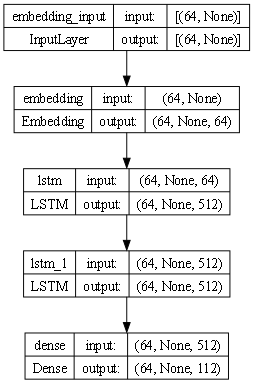

In [32]:
plot_model(rnn_char, 'images/rnn_char_model.png', show_shapes=True, dpi=70)

Проверка модели на восприятие датасета на примере первой последовательности:

In [33]:
test_single_model(rnn_char, data_char, vocabulary_char)

Размерность целевой последовательности: (64, 99)
Размерность предсказанной последовательности: (64, 99, 112)
Размерность тензора с 1 индексом классов (99, 1)
Индекс класса: 15 (0)


---

### 3.3 Обучение модели

Задание функции построения графика значений функции потерь:

In [34]:
def plot_performance(history: History, title: str) -> None:
    font_s = 12
    plt.figure(figsize=(6,5))
    
    loss = history.history['loss']
    
    plt.plot(loss, '+-r')
    
    plt.title(f'{title}\n', size=font_s+4)
    
    plt.xlabel('Epoch', size=font_s,)
    plt.ylabel('Loss', size=font_s)
    
    plt.xticks(range(len(loss)))
    plt.grid()
    plt.show()

---

Проверка наличия папки для хранения контрольных точек:

In [35]:
if os.path.isdir('checkpoints/') == False:
    os.mkdir('checkpoints/')

Задание пути для хранения контрольных точек:

In [36]:
path_checkpoints = 'checkpoints/rnn_char'

Проверка наличия папки для хранения контрольных точек:

In [37]:
if os.path.isdir(path_checkpoints) == False:
    os.mkdir(path_checkpoints)

Задание коллбека точек сохранения:

In [38]:
checkpoint_path = os.path.join(path_checkpoints, 'checkpoint_{epoch}')
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

Компиляция модели с оптимизатором и функцией потерь:

In [39]:
rnn_char.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True))

Обучение модели:

In [ ]:
history_char = rnn_char.fit(
    data_char, 
    epochs=20, 
    steps_per_epoch=BATCHES_PER_EPOCH, 
    callbacks=[checkpoint_callback]
)

Epoch 1/20
563/563 [==============================] - 842s 1s/step - loss: 2.6849
Epoch 2/20
563/563 [==============================] - 839s 1s/step - loss: 1.9134
Epoch 3/20
563/563 [==============================] - 825s 1s/step - loss: 1.5795
Epoch 4/20
563/563 [==============================] - 820s 1s/step - loss: 1.4477
Epoch 5/20
563/563 [==============================] - 814s 1s/step - loss: 1.3749
Epoch 6/20
563/563 [==============================] - 818s 1s/step - loss: 1.3258
Epoch 7/20
563/563 [==============================] - 814s 1s/step - loss: 1.2886
Epoch 8/20
563/563 [==============================] - 814s 1s/step - loss: 1.2584
Epoch 9/20
254/563 [============>.................] - ETA: 7:44 - loss: 1.2500

Выведение на экран графика значений функции потерь:

In [ ]:
plot_performance(history_char, 'Значение функции потерь')

Сброс состояния модели:

In [ ]:
rnn_char.reset_states()

---

### 3.4 Генерация текста

Задание функции обучения модели:

In [ ]:
def predict_next(sample: str,
                 model: Sequential,
                 tokenizer: dict,
                 vocabulary: dict,
                 seq_len: int,
                 temperature: float,
                 batch_size: int,
                 word: bool = False) -> str:
    
    sample_vector = [tokenizer[s] for s in sample]
    predicted = sample_vector
    
    sample_tensor = tf.expand_dims(sample_vector, 0)
    sample_tensor = tf.repeat(sample_tensor, batch_size, axis=0)

    for i in range(seq_len):
        pred = model(sample_tensor)
        
        pred = pred[0].numpy() / temperature
        pred = tf.random.categorical(pred, num_samples=1)[-1, 0].numpy()
        
        predicted.append(pred)
        
        sample_tensor = predicted[-99:]
        sample_tensor = tf.expand_dims([pred], 0)
        
        sample_tensor = tf.repeat(sample_tensor, batch_size, axis=0)
        
    pred_seq = [vocabulary[i] for i in predicted]
    generated = ' '.join(pred_characters) if word else ''.join(pred_seq)
    
    return generated

---

Выведение на экран результата предсказаний:

In [ ]:
predict_next(
    sample='гарри', 
    model=rnn_char,
    tokenizer=tokenizer_char,
    vocabulary=vocabulary_char,
    seq_len=1000, 
    temperature=0.6,
    batch_size=BATCH_SIZE
)

Выведение на экран результата предсказаний:

In [ ]:
predict_next(
    sample='гарри', 
    model=rnn_char,
    tokenizer=tokenizer_char,
    vocabulary=vocabulary_char,
    seq_len=1000, 
    temperature=0.8,
    batch_size=BATCH_SIZE
)

>Модель продемонстрировала хорошую предсказательную способность.

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>